In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
'''Consider the discrete-time asset allocation example in section 8.4 of Rao and Jelvis. Suppose the single-time-step return of the risky asset from time t to t+1 as Yt = a, prob = p
and b, prob = (1-p). Suppose that T=10, use the TD method to find the Q function and hence the optimal strategy'''

'Consider the discrete-time asset allocation example in section 8.4 of Rao and Jelvis. Suppose the single-time-step return of the risky asset from time t to t+1 as Yt = a, prob = p\nand b, prob = (1-p). Suppose that T=10, use the TD method to find the Q function and hence the optimal strategy'

In [1]:
from __future__ import annotations
from abc import ABC, abstractmethod
from dataclasses import dataclass
from collections import defaultdict
from scipy.stats import binom
import numpy as np
from typing import Dict, Sequence
import itertools
import random
import operator
from operator import itemgetter

'''
Initial Assumptions
- Discrete Time
- Discrete Returns: +/-1 (daily)
- 1 Stock - Follows Binomial Distribution payout
- Utility - CARA function for final step reward Constant Absolute Risk Aversion
- T = 10 based on Assignment specification
- No fractional investments (i.e. only units)
- Assuming W_0 initial wealth = 0
- Assume NO CONSUMPTION of wealth at any Time t<T - i.e. Reward = 0 for 0<=t<T and utility at T
- Unconstrained allocation amount
''' 

'''
Shorting has a small benefit here - this world assumes no borrowing cost and returns are binary (i.e. won't explode to infinity) which means when you short,
You actually earn interest on the cash you get by shorting.
'''

ITERATIONS=10
GAMMA=1
COEFFICIENT_OF_CARA=1
INVESTMENT_LIMIT_MAX=1
INVESTMENT_LIMIT_MIN=0
SPLITS=2
RESOLUTION=1e-2
RISK_FREE_RATE=0.05
PROBABILITY_PRICE_UP=0.6 #Probability of risky asset increasing
PRICE_A=0.3
PRICE_B=-0.1
INITIAL_WEALTH=1
RISKY_RETURN_DISTRIBUTION={PRICE_A:PROBABILITY_PRICE_UP, PRICE_B:1-PROBABILITY_PRICE_UP}

'''State'''
@dataclass(frozen=True)
class WealthState:
    time: int #time state I am in
    wealth: float
    termination_time:int = ITERATIONS
    
    def __eq__(self, other):
        return (self.time == other.time) and \
               (self.wealth == other.wealth)
    
    def isTerminal(self):
        return self.time == self.termination_time

'''ACTIONS'''
@dataclass(frozen=True)
class InvestmentAction:
    risky_investment_amount: float
    
    def __eq__(self, other):
        return self.risky_investment_amount == other.risky_investment_amount
    
    def action_to_next_state(self, ws: WealthState, risky_return, risk_free_rate) -> WealthState:
        next_expected_wealth = wealth_func(ws, self.risky_investment_amount, risky_return, risk_free_rate)
        new_state = WealthState(time=ws.time+1, 
                                wealth=next_expected_wealth,
                               )
        return new_state
    
    @staticmethod
    def get_all_actions(investment_limit_min: int = INVESTMENT_LIMIT_MAX,
                        invesment_limit_max: int = INVESTMENT_LIMIT_MIN,
                        splits: int = SPLITS
                       ) -> Sequence[InvestmentAction]:
        all_actions = list()
        allocations = np.linspace(investment_limit_min,invesment_limit_max,splits).tolist()
        for alloc in allocations:
            all_actions.append(InvestmentAction(risky_investment_amount=alloc))
        
        return all_actions
    
'''REWARD'''
'''CARA UTILITY'''
def cara_func(x :float, alpha=COEFFICIENT_OF_CARA) -> float:
    return - np.exp(-alpha * x)/alpha

def wealth_func(ws: WealthState, risky_asset_allocation, risky_asset_return:float , risk_free_return:float = RISK_FREE_RATE) -> float:
    # print(f'{risky_asset_allocation} * ({risky_asset_return} - {risk_free_return}) + {ws.wealth} * {(1 + risk_free_return)}')
    wealth = risky_asset_allocation * (risky_asset_return - risk_free_return) + ws.wealth * (1 + risk_free_return)
    return wealth

'''TRANSITIONS'''
'''Essentially, its a map of possible states at a given time assuming all actions
are applied to each state - every action will result in 2 states (price up and price down)'''
def get_all_state_actions(
    iterations, 
    available_actions, 
    initial_state, 
    risky_return_distribution=RISKY_RETURN_DISTRIBUTION,
    risk_free_rate=RISK_FREE_RATE
) \
-> Sequence[Dict[WealthState, Dict[WealthState, float]]]:
    state_tree = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
    current_states = [initial_state]
    for i in range(iterations):
        next_states_list = set()
        for state in current_states:
            for action , action_prob in available_actions.items():
                for risky_return, risky_return_prob in risky_return_distribution.items():
                    next_state = action.action_to_next_state(state,risky_return,risk_free_rate)
                    state_tree[state][action][next_state]+= risky_return_prob * action_prob
                    next_states_list.add(next_state)

        current_states = next_states_list
    return state_tree

initial_state = WealthState(time=0,wealth=INITIAL_WEALTH)
all_actions = InvestmentAction.get_all_actions()
initial_actions = {a: 1/len(all_actions) for a in all_actions}
all_state_actions = get_all_state_actions(ITERATIONS, initial_actions, initial_state)

'''
1. Decrement from time T back down to 0 to calculate the values for each state.
2. each time_step: T-1 = r + discount * E[G_T+1|S]
'''
#Define a state action reward mapping - for each time - state:{action:{next_state: expected_reward <-- cause its probabilistic}}
#Applicable for finite states only.
def get_state_action_value_map(state_actions, reward_func=cara_func, gamma=GAMMA, iterations=ITERATIONS):
    
    def get_reward(state,action):
        next_states_probablity = state_actions[state][action]
        total_reward = 0
        for next_state, action_return_probability in next_states_probablity.items():
            if next_state.isTerminal():
                utility = reward_func(next_state.wealth)
                total_reward += utility * action_return_probability
                # print(f'Utility: {utility}, Action: {action}, Prob: {action_return_probability}, Total reward: {total_reward}')
            else:
                next_state_actions = state_actions[next_state]
                for next_action, _ in next_state_actions.items():
                    total_reward += get_reward(next_state,next_action) * action_return_probability
        
        # print(f'State: {state} , Action: {action}, Reward: {total_reward}')
        return total_reward
            
    state_action_value_map = defaultdict(lambda: defaultdict(float))
    for i in reversed(range(iterations)):
        states_at_t = [state for state in state_actions.keys() if state.time == i]
        for (state_at_t) in states_at_t:
            next_state_actions = state_actions[state_at_t]
            discount = gamma ** (iterations - i)
            for action, next_states in next_state_actions.items():
                reward = get_reward(state_at_t,action)
                state_action_value_map[state_at_t][action] = discount * reward 
    
    return state_action_value_map

state_action_value_map = get_state_action_value_map(all_state_actions)
        
def retrieve_optimal_policy_from_values(state_action_value_map):
    policy = defaultdict(lambda: defaultdict(float))
    for state, action_values in state_action_value_map.items():
        action = max(action_values, key=action_values.get)
        value = action_values[action]
        policy[state][action]=1
    return policy
        
# retrieve_optimal_policy_from_values(state_action_value_map)
policy = retrieve_optimal_policy_from_values(state_action_value_map)
def execute_policy(policy,initial_state,risky_return_dist,risk_free_rate):
    state = initial_state
    iterations = state.termination_time
    for i in range(iterations):
        action_probs = policy[state]
        action = max(action_probs, key=action_probs.get)
        risky_return = np.random.choice([*RISKY_RETURN_DISTRIBUTION.keys()], 
                                     p=[*RISKY_RETURN_DISTRIBUTION.values()])
        next_state = action.action_to_next_state(state,risky_return,risk_free_rate)
        print(f'State: {state}, Action: {action}')
        state = next_state

execute_policy(policy,initial_state,RISKY_RETURN_DISTRIBUTION,RISK_FREE_RATE)

State: WealthState(time=0, wealth=1, termination_time=10), Action: InvestmentAction(risky_investment_amount=1.0)
State: WealthState(time=1, wealth=0.9, termination_time=10), Action: InvestmentAction(risky_investment_amount=1.0)
State: WealthState(time=2, wealth=0.795, termination_time=10), Action: InvestmentAction(risky_investment_amount=1.0)
State: WealthState(time=3, wealth=1.08475, termination_time=10), Action: InvestmentAction(risky_investment_amount=1.0)
State: WealthState(time=4, wealth=0.9889875000000002, termination_time=10), Action: InvestmentAction(risky_investment_amount=1.0)
State: WealthState(time=5, wealth=0.8884368750000003, termination_time=10), Action: InvestmentAction(risky_investment_amount=1.0)
State: WealthState(time=6, wealth=0.7828587187500003, termination_time=10), Action: InvestmentAction(risky_investment_amount=1.0)
State: WealthState(time=7, wealth=0.6720016546875004, termination_time=10), Action: InvestmentAction(risky_investment_amount=1.0)
State: WealthSta

In [3]:
value_function_data = defaultdict(float)

def execute_monte_carlo():
    initial_state = [state for state in all_state_actions.keys() if state.time == 0][0] #only one for now
    state = initial_state
    total_reward = 0
    visited_state_actions = []
    for t in range(ITERATIONS):
        actions = [*all_state_actions[state].keys()]
        chosen_action = np.random.choice(actions)
        risky_return = np.random.choice([*RISKY_RETURN_DISTRIBUTION.keys()], 
                                     p=[*RISKY_RETURN_DISTRIBUTION.values()])
        next_state = chosen_action.action_to_next_state(state,risky_return,0.01)
        total_reward += cara_func(next_state.wealth)
        visited_state_actions.append((state,chosen_action))
        state = next_state
    
    for v in visited_state_actions:
        value_function_data[v] = value_function_data[v] + total_reward/len(visited_state_actions)

for i in range(10000):
    execute_monte_carlo()

for t in range(ITERATIONS):
    actions_in_t = [(s,value) for s, value in value_function_data.items() if s[0].time==t]
    best_action = max(actions_in_t,key=itemgetter(1))[0]
    print(f'At Time: {t}, Do: {best_action}')

ValueError: 'a' cannot be empty unless no samples are taken

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Time: 0 - Optimal Allocation: 1.4766229390345276, Expected Utility: -0.26394818059500247
Time: 1 - Optimal Allocation: 1.5504540859862541, Expected Utility: -0.21377255379436755
Time: 2 - Optimal Allocation: 1.6279767902855669, Expected Utility: -0.17010850423031865
Time: 3 - Optimal Allocation: 1.709375629799845, Expected Utility: -0.13283386358404797
Time: 4 - Optimal Allocation: 1.7948444112898374, Expected Utility: -0.10165634914790152
Time: 5 - Optimal Allocation: 1.8845866318543296, Expected Utility: -0.076138037697676
Time: 6 - Optimal Allocation: 1.9788159634470461, Expected Utility: -0.055727689002467676
Time: 7 - Optimal Allocation: 2.0777567616193986, Expected Utility: -0.03979817779113723
Time: 8 - Optimal Allocation: 2.181644599700369, Expected Utility: -0.02768574732260907
Time: 9 - Optimal Allocation: 2.2907268296853873, Expected Utility: -0.01872764901152027


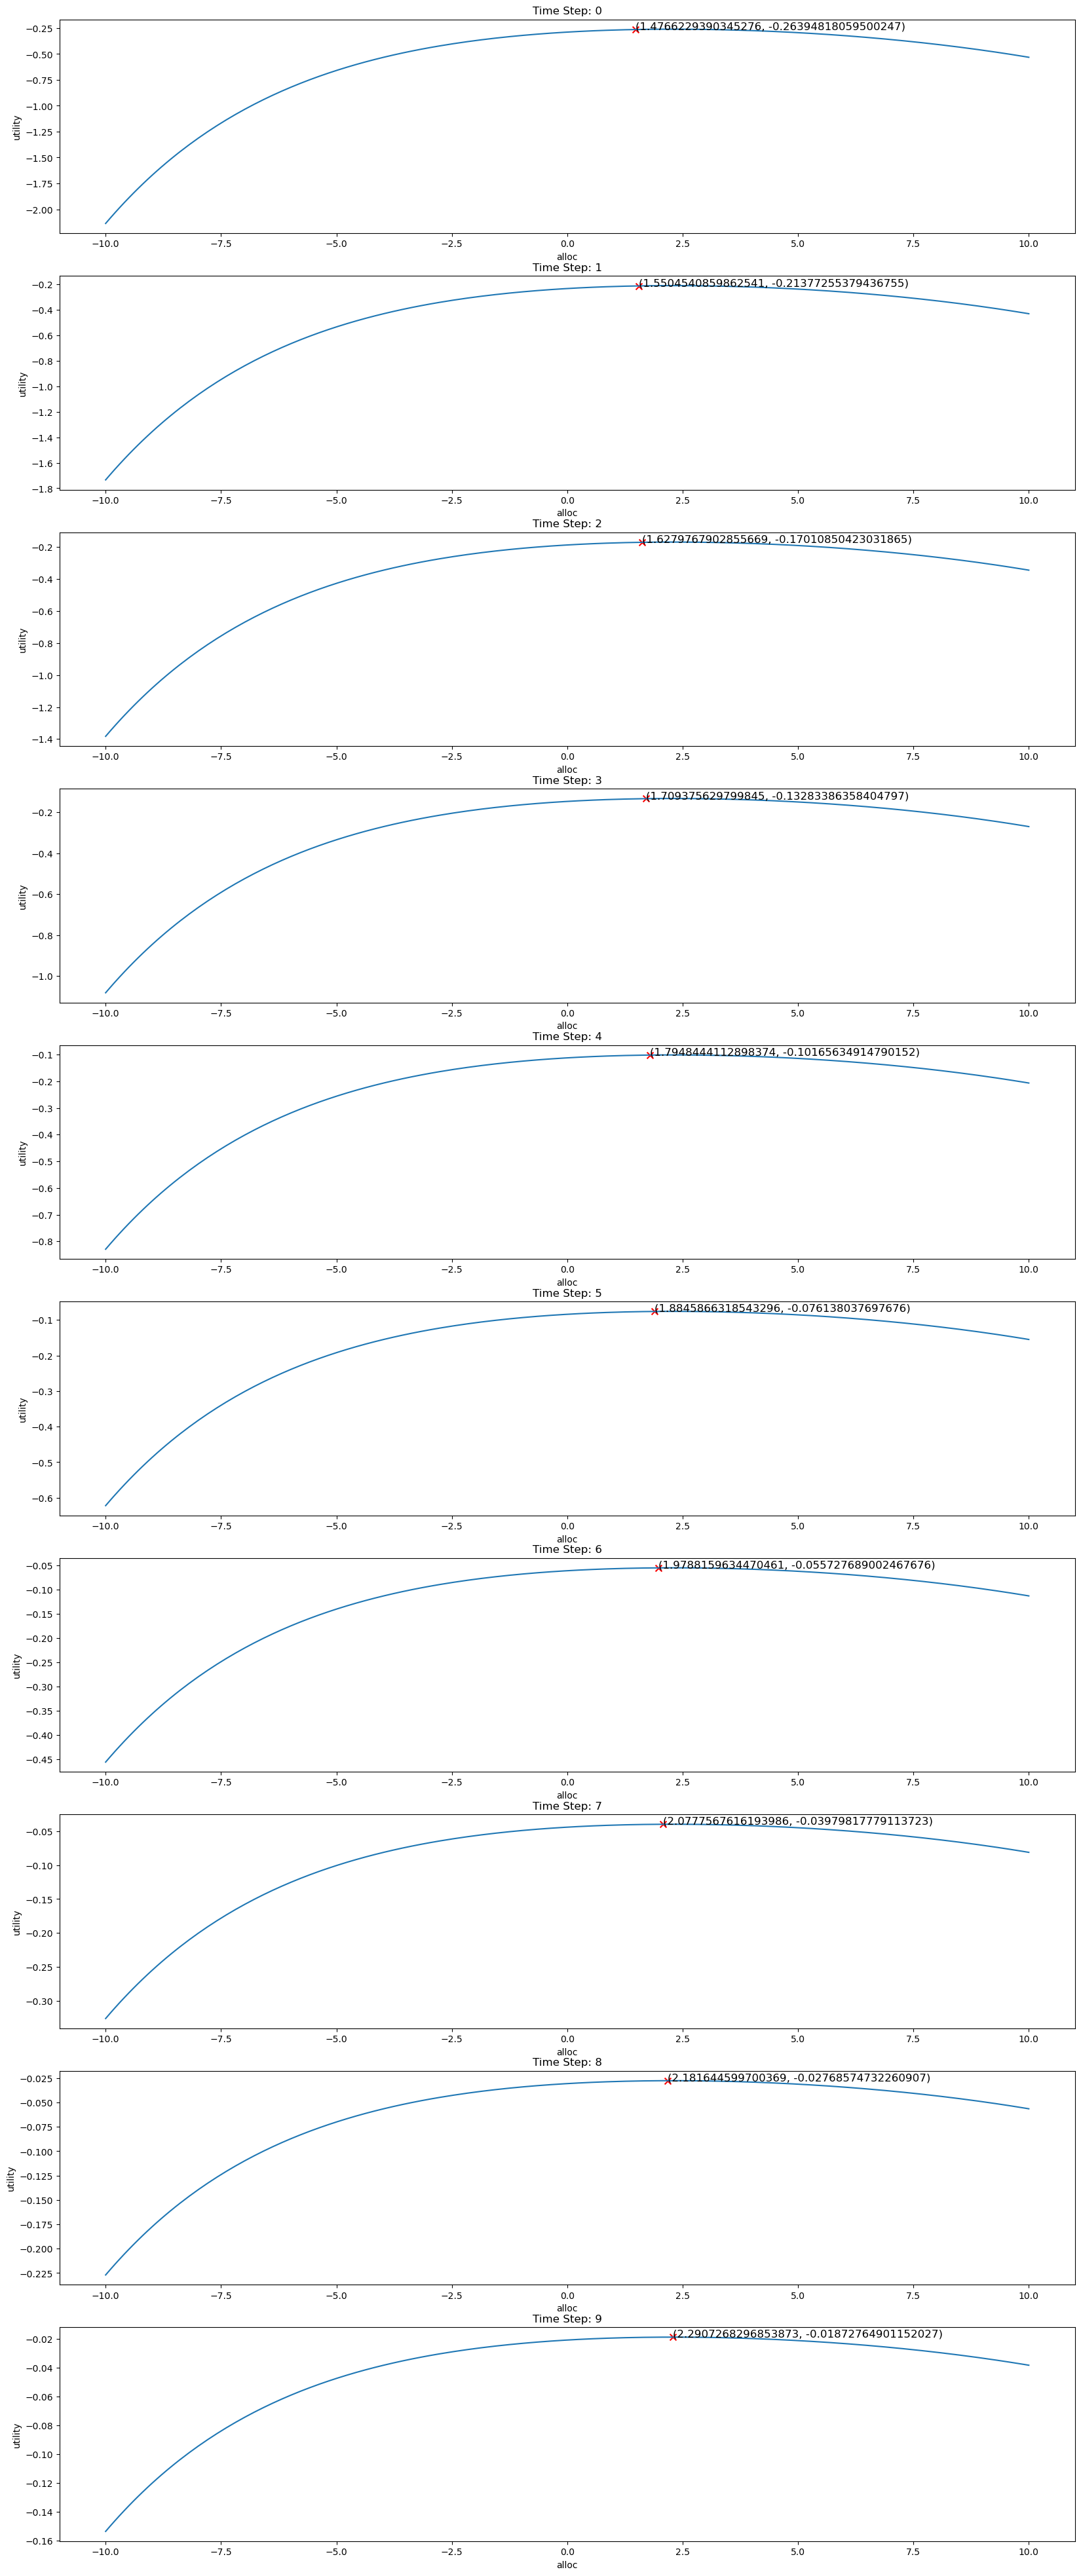

In [11]:
'''optimal_step_analytical'''
import matplotlib.pyplot as plt

def analytical_solution(x, iterations=ITERATIONS):
    probability_part = np.log((PROBABILITY_PRICE_UP * (RISK_FREE_RATE - PRICE_A)) / ((PROBABILITY_PRICE_UP-1) * (RISK_FREE_RATE - PRICE_B)))
    time_part = COEFFICIENT_OF_CARA * ( (1 + RISK_FREE_RATE) ** (iterations - x - 1) ) * (PRICE_A - PRICE_B)
    optimal_step = (1/time_part) * probability_part
    return(optimal_step)

def expected_utility(x, WEALTH=INITIAL_WEALTH):
    price_a_wealth = PROBABILITY_PRICE_UP * np.exp(-COEFFICIENT_OF_CARA * (x * (PRICE_A - RISK_FREE_RATE)))
    price_b_wealth = (1-PROBABILITY_PRICE_UP) * np.exp(-COEFFICIENT_OF_CARA * (x * (PRICE_B - RISK_FREE_RATE)))
    risk_free_wealth = np.exp(-COEFFICIENT_OF_CARA * WEALTH * (1 + RISK_FREE_RATE))
    return - (risk_free_wealth * (price_a_wealth + price_b_wealth))/COEFFICIENT_OF_CARA

time_step = [ _ for _ in range(ITERATIONS) ]
print(time_step)
wealth = 1
risk_free = 0.05
risky_asset_return_dist = {
    0.3:0.6,
    -0.1:0.4
}
x = np.linspace(-10, 10, 200)
fig, axs = plt.subplots(len(time_step),figsize=(20, 5 * len(time_step)))
for time in time_step:
    step = time
    optimal_alloc = analytical_solution(step)
    expected_wealth = 0
    for returns, prob in risky_asset_return_dist.items():
        expected_wealth += prob * (optimal_alloc * (returns - risk_free) + wealth * (1 + risk_free))
    
    wealth=expected_wealth
    y = [expected_utility(c,wealth) for c in x ]
    y_alloc = expected_utility(optimal_alloc,wealth)
    axs[time].plot(x,y)
    axs[time].scatter([optimal_alloc],[y_alloc],color='r',s=50,marker='x')
    axs[time].text(optimal_alloc, y_alloc, '({}, {})'.format(optimal_alloc, y_alloc),fontsize
='large')
    axs[time].set_title(f'Time Step: {time}')
    axs[time].set_xlabel('alloc')
    axs[time].set_ylabel('utility')
    print(f'Time: {time} - Optimal Allocation: {optimal_alloc}, Expected Utility: {y_alloc}')

plt.show()

### Test Functions

In [85]:
import unittest

def assert_lists_no_order(test_case, list1,list2):
    for i in list1:
        test_case.assertIn(i,list2)
        
    for i in list2:
        test_case.assertIn(i,list1)
        
class TestWealthState(unittest.TestCase):
    ws = WealthState(time=0,wealth=10)
    
    def testWealthStateEquality(self):
        self.assertEqual(self.ws.time,0)
        self.assertEqual(self.ws.wealth,10)

class TestInvestmentAction(unittest.TestCase):
    ia = InvestmentAction(risky_investment_amount=1)
    ws = WealthState(time=0,wealth=10)
    
    def testNextState(self):
        ns = self.ia.action_to_next_state(self.ws,0.2,0.01)
        self.assertEqual(ns.time,1)
        self.assertEqual(ns.wealth,10.29)

    def testGetAllActions_Investment_Limit_1(self):
        ia = InvestmentAction(risky_investment_amount=1)
        actions = InvestmentAction.get_all_actions(1,-1,3)
        expected_actions = [
            InvestmentAction(risky_investment_amount=1),
            InvestmentAction(risky_investment_amount=0),
            InvestmentAction(risky_investment_amount=-1)
        ]
        assert_lists_no_order(self,actions,expected_actions)
        
class TestCARAUtility(unittest.TestCase):
     def testCARA(self):
        # -( e ^ (- alpha * Wt) )/alpha
        self.assertEqual(cara_func(1, alpha=1),-1/np.e)
        self.assertEqual(cara_func(1, alpha=2), - ((np.e ** (-2 * 1))/2))

class TestWealthFunction(unittest.TestCase):
# def wealth_func(ws: WealthState, 
# risky_asset_allocation, 
# risky_asset_return:float , 
# risk_free_return:float = RISK_FREE_RATE) -> float:

    def testWealthFunction_Price_0_0_Risky_Asset(self):
        ws = WealthState(time=0,wealth=1)
        self.assertEqual(wealth_func(ws,0,0,0),1)
        
    def testWealthFunction_Price_1_0_Risky_Asset(self):
        ws = WealthState(time=0,wealth=1)
        self.assertEqual(wealth_func(ws,0,1,0),1)

    def testWealthFunction_Price_0_1_Risky_Asset(self):
        ws = WealthState(time=0,wealth=1)
        self.assertEqual(wealth_func(ws,1,0,0),1)
        
    def testWealthFunction_Price_2_1_Risky_Asset(self):
        ws = WealthState(time=0,wealth=1)
        self.assertEqual(wealth_func(ws,1,2,0),3)
        
    def testWealthFunction_Price_neg_3_2_Risky_Asset(self):
        ws = WealthState(time=0,wealth=1)
        self.assertEqual(wealth_func(ws,2,-3,0),-5)

    def testWealthFunction_Price_neg_3_2_Risky_Asset_1bps_Risk_Free_Rate(self):
        ws = WealthState(time=0,wealth=1)
        self.assertEqual(wealth_func(ws,2,-3,0.01),-5.01)


# def get_all_state_actions(iterations, available_actions, initial_state, risky_return_distribution=RISKY_RETURN_DISTRIBUTION) \
class TestGetAllStateActions(unittest.TestCase):
    risky_return_dist = {
        0.1: 0.5,
        -0.1: 0.5
    }
    def testGet_All_State_Actions_1_time_step(self):
        ws= WealthState(time=0,wealth=0,termination_time=1)
        actions = {
            InvestmentAction(risky_investment_amount=1):0.5,
            InvestmentAction(risky_investment_amount=0):0.5
        }
        all_state_actions = get_all_state_actions(1,actions,ws,self.risky_return_dist,0)
        expected_state_actions = {
            ws: {
                InvestmentAction(risky_investment_amount=1):{
                    WealthState(time=1,wealth=0.1):0.25,
                    WealthState(time=1,wealth=-0.1):0.25
                },
                InvestmentAction(risky_investment_amount=0):{
                    WealthState(time=1,wealth=0):0.5 #This zero case should've been tested earlier =.=
                }
            }
        }
        self.assertEqual(expected_state_actions,all_state_actions)
        
    def testGet_All_State_Actions_2_time_step(self):
        ws= WealthState(time=0,wealth=0,termination_time=2)
        actions = {
            InvestmentAction(risky_investment_amount=1):0.5,
            InvestmentAction(risky_investment_amount=0):0.5
        }        
        all_state_actions = get_all_state_actions(2,actions,ws,self.risky_return_dist,0)
        expected_state_actions = {
            WealthState(time=0,wealth=0,termination_time=2): {
                InvestmentAction(risky_investment_amount=1):{
                    WealthState(time=1,wealth=0.1):0.25,
                    WealthState(time=1,wealth=-0.1):0.25
                },
                InvestmentAction(risky_investment_amount=0):{
                    WealthState(time=1,wealth=0):0.5
                }
            },
            WealthState(time=1,wealth=0.1,termination_time=2): {
                InvestmentAction(risky_investment_amount=1):{
                    WealthState(time=2,wealth=0.2):0.25,
                    WealthState(time=2,wealth=0):0.25
                },
                InvestmentAction(risky_investment_amount=0):{
                    WealthState(time=2,wealth=0.1):0.5
                }
            },
            WealthState(time=1,wealth=-0.1,termination_time=2): {
                InvestmentAction(risky_investment_amount=1):{
                    WealthState(time=2,wealth=0):0.25,
                    WealthState(time=2,wealth=-0.2):0.25
                },
                InvestmentAction(risky_investment_amount=0):{
                    WealthState(time=2,wealth=-0.1):0.5
                }
            },
            WealthState(time=1,wealth=0,termination_time=2): {
                InvestmentAction(risky_investment_amount=1):{
                    WealthState(time=2,wealth=0.1):0.25,
                    WealthState(time=2,wealth=-0.1):0.25
                },
                InvestmentAction(risky_investment_amount=0):{
                    WealthState(time=2,wealth=0):0.5
                }
            }
        } 
        
        for state, action_vals in all_state_actions.items():
            print(expected_state_actions[state])
            print(action_vals)
        self.assertEqual(expected_state_actions,all_state_actions)

class TestGetStateActionValueMap(unittest.TestCase):
    def testGetStateActionValueMap_1_iteration(self):
        gamma = 1
        probability = 0.5
        state_actions = {
            WealthState(time=0,wealth=0,termination_time=1): {
                InvestmentAction(risky_investment_amount=1):{
                    WealthState(time=1,wealth=0.2,termination_time=1):0.25,
                    WealthState(time=1,wealth=-0.1,termination_time=1):0.25
                },   
                InvestmentAction(risky_investment_amount=0):{
                    WealthState(time=1,wealth=0,termination_time=1):0.5,
                }
            }
        }
        
        expected_state_action_value_map = defaultdict(float)
        expected_state_action_value_map.update({
            WealthState(time=0,wealth=0,termination_time=1): {
                InvestmentAction(risky_investment_amount=1):0.025,
                InvestmentAction(risky_investment_amount=0):0
        }})
        result = get_state_action_value_map(state_actions,reward_func=lambda x: x,gamma=1,iterations=1)
        self.assertEqual(expected_state_action_value_map,result)
        
    def testGetStateActionValueMap_2_iteration(self):
        state_actions = {
            WealthState(time=0,wealth=0,termination_time=2): {
                InvestmentAction(risky_investment_amount=1):{
                    WealthState(time=1,wealth=0.1):0.25,
                    WealthState(time=1,wealth=-0.1):0.25
                },
                InvestmentAction(risky_investment_amount=0):{
                    WealthState(time=1,wealth=0):0.5
                }
            },
            WealthState(time=1,wealth=0.1,termination_time=2): {
                InvestmentAction(risky_investment_amount=1):{
                    WealthState(time=2,wealth=0.2):0.25,
                    WealthState(time=2,wealth=0):0.25
                },
                InvestmentAction(risky_investment_amount=0):{
                    WealthState(time=2,wealth=0.1):0.5
                }
            },
            WealthState(time=1,wealth=-0.1,termination_time=2): {
                InvestmentAction(risky_investment_amount=1):{
                    WealthState(time=2,wealth=0):0.25,
                    WealthState(time=2,wealth=-0.2):0.25
                },
                InvestmentAction(risky_investment_amount=0):{
                    WealthState(time=2,wealth=-0.1):0.5
                }
            },
            WealthState(time=1,wealth=0,termination_time=2): {
                InvestmentAction(risky_investment_amount=1):{
                    WealthState(time=2,wealth=0.1):0.25,
                    WealthState(time=2,wealth=-0.1):0.25
                },
                InvestmentAction(risky_investment_amount=0):{
                    WealthState(time=2,wealth=0):0.5
                }
            }
        }  
        
        expected_state_action_value_map = defaultdict(float)
        expected_state_action_value_map.update({
            WealthState(time=0,wealth=0,termination_time=2): {
                InvestmentAction(risky_investment_amount=1):0,
                InvestmentAction(risky_investment_amount=0):0
            },
            WealthState(time=1,wealth=0.1,termination_time=2): {
                InvestmentAction(risky_investment_amount=1):0.05,
                InvestmentAction(risky_investment_amount=0):0.05
            },
            WealthState(time=1,wealth=-0.1,termination_time=2): {
                InvestmentAction(risky_investment_amount=1):-0.05,
                InvestmentAction(risky_investment_amount=0):-0.05
            },
            WealthState(time=1,wealth=0,termination_time=2): {
                InvestmentAction(risky_investment_amount=1):0,
                InvestmentAction(risky_investment_amount=0):0
            }
        })
        result = get_state_action_value_map(state_actions,reward_func=lambda x: x,gamma=1,iterations=2)
        self.assertEqual(expected_state_action_value_map,result)
        
unittest.main(argv=[''], verbosity=2, exit=False)

testCARA (__main__.TestCARAUtility) ... ok
testGet_All_State_Actions_1_time_step (__main__.TestGetAllStateActions) ... ok
testGet_All_State_Actions_2_time_step (__main__.TestGetAllStateActions) ... ok
testGetStateActionValueMap_1_iteration (__main__.TestGetStateActionValueMap) ... ok
testGetStateActionValueMap_2_iteration (__main__.TestGetStateActionValueMap) ... ok
testGetAllActions_Investment_Limit_1 (__main__.TestInvestmentAction) ... ok
testNextState (__main__.TestInvestmentAction) ... ok
testWealthFunction_Price_0_0_Risky_Asset (__main__.TestWealthFunction) ... ok
testWealthFunction_Price_0_1_Risky_Asset (__main__.TestWealthFunction) ... ok
testWealthFunction_Price_1_0_Risky_Asset (__main__.TestWealthFunction) ... ok
testWealthFunction_Price_2_1_Risky_Asset (__main__.TestWealthFunction) ... ok
testWealthFunction_Price_neg_3_2_Risky_Asset (__main__.TestWealthFunction) ... ok
testWealthFunction_Price_neg_3_2_Risky_Asset_1bps_Risk_Free_Rate (__main__.TestWealthFunction) ... ok
testWe

{InvestmentAction(risky_investment_amount=1): {WealthState(time=1, wealth=0.1, termination_time=2): 0.25, WealthState(time=1, wealth=-0.1, termination_time=2): 0.25}, InvestmentAction(risky_investment_amount=0): {WealthState(time=1, wealth=0, termination_time=2): 0.5}}
defaultdict(<function get_all_state_actions.<locals>.<lambda>.<locals>.<lambda> at 0x7fc157603170>, {InvestmentAction(risky_investment_amount=1): defaultdict(<class 'float'>, {WealthState(time=1, wealth=0.1, termination_time=2): 0.25, WealthState(time=1, wealth=-0.1, termination_time=2): 0.25}), InvestmentAction(risky_investment_amount=0): defaultdict(<class 'float'>, {WealthState(time=1, wealth=0.0, termination_time=2): 0.5})})
{InvestmentAction(risky_investment_amount=1): {WealthState(time=2, wealth=0, termination_time=2): 0.25, WealthState(time=2, wealth=-0.2, termination_time=2): 0.25}, InvestmentAction(risky_investment_amount=0): {WealthState(time=2, wealth=-0.1, termination_time=2): 0.5}}
defaultdict(<function get_

ok

----------------------------------------------------------------------
Ran 14 tests in 0.019s

OK
